In [1]:
import numpy as np
import re, json, csv
import torch
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable
from bson.objectid import ObjectId
from torchmetrics.text.bert import BERTScore
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bleu import BLEUScore
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoConfig, AutoTokenizer
from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.functional.text.bert import _get_precision_recall_f1
from functools import partial
from collections import Counter, defaultdict
from itertools import chain
from math import log
from multiprocessing import Pool
from typing import List
from pymongo import MongoClient
from typing import Set

from src.baseline.model import Model
from src.baseline.search import GreedySearch

pprint = PrettyPrinter().pprint

In [2]:
DEVICE = "cpu"

In [3]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]

### Get model

### Calculate ROUGE

In [4]:
def compute_rouge_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    tokenizer_fn = lambda x: tokenizer.convert_ids_to_tokens(tokenizer.encode(x))
    rouge_metric = ROUGEScore(tokenizer=tokenizer_fn)
    # rouge_metric.update(pred_senteces, target_sentences)
    return rouge_metric(pred_senteces, target_sentences)

### Calculate BLEU

In [5]:
def compute_bleu_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    bleu_metric = BLEUScore(tokenizer=tokenizer)
    bleu_metric.update(pred_senteces, [[s] for s in target_sentences])
    return bleu_metric.compute()

### Calculate BERT score

In [6]:
def update(self, preds: List[str], targets: List[str]) -> None:
        """Store predictions/references for computing BERT scores.

        It is necessary to store sentences in a tokenized form to ensure the DDP mode working.
        """
        
        preds_tokenized_data = self.tokenizer(preds, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        preds_dict = {"input_ids": preds_tokenized_data["input_ids"], "attention_mask": preds_tokenized_data["attention_mask"]}
        target_tokenized_data = self.tokenizer(targets, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        target_dict = {"input_ids": target_tokenized_data["input_ids"], "attention_mask": target_tokenized_data["attention_mask"]}

        self.preds_input_ids.append(preds_dict["input_ids"])
        self.preds_attention_mask.append(preds_dict["attention_mask"])
        self.target_input_ids.append(target_dict["input_ids"])
        self.target_attention_mask.append(target_dict["attention_mask"])
        
def compute_bert_score2(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer, model : torch.nn.Module, *args, **kwargs):
    BERTScore.update = update
    user_forward_fn = lambda model, d: model.get_input_embeddings()(d["input_ids"])
    bert_metric = BERTScore(model=model, user_tokenizer=tokenizer, user_forward_fn=user_forward_fn, device=DEVICE, verbose=True, num_layers=0, max_length=600)
    # bert_metric.update = update
    output = {}
    for key, vals in bert_metric(preds=pred_senteces, targets=target_sentences).items():
        output[key] = float(np.mean(vals))
    
    return output
#     bert_metric.update(bert_metric, pred_senteces, target_sentences)
#     return bert_metric.compute()

In [7]:
def get_kernel_prefixes(kernel : str) -> Set[str]:
    prefixes = set()
    one_line_kernel = kernel.replace("\n", " ")
    cuda_header_prefix_re = re.compile("__(host|global|device)__")
    
    prefixes.update(cuda_header_prefix_re.findall(one_line_kernel))
    return prefixes
        

In [8]:
def compute_metrics(sources : List[str], targets : List[str], preds : List[str], tokenizer, model : torch.nn.Module, used_ratio : float = 1.0):
    assert used_ratio > 0 and used_ratio <= 1
    assert len(targets) == len(preds)
    
    samples = list(zip(targets, preds))
    np.random.shuffle(samples)
    n = round(len(samples) * used_ratio)
    
    print(f"Using random {n} samples")
        
    metrics_d = {
        "device" : {},
        "host" : {},
        "global" : {}
    }
    
    device_sentences = []
    host_sentences = []
    global_sentences = []
    
    pb = tqdm(zip(sources, targets, preds))
    i = 0
    for src, target, pred in pb:
        found = False
        
        if found := (src.find("__device__") != -1):
            device_sentences.append((target, pred))
        if found := (src.find("__host__") != -1):
            host_sentences.append((target, pred))
        if found := (src.find("__global__") != -1):
            global_sentences.append((target, pred))
        
        if not found:
            continue
        
        i += 1
        pb.set_description_str(f"{i}")
        if i >= n:
            break
    
    if len(device_sentences) == 0:
        print("WARNING: no device sample")
        # metrics_d["__device__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        device_targets, device_preds = zip(*device_sentences)
        metrics_d["device"] = {
            "rouge" : compute_rouge_score(device_targets, device_preds, tokenizer),
            "bleu" : compute_bleu_score(device_targets, device_preds, tokenizer),
            "bert" : compute_bert_score2(device_targets, device_preds, tokenizer, model)
        }
        print(f"__device__ ({len(device_sentences)})")
        pprint(metrics_d["device"])
        
    if len(host_sentences) == 0:
        print("WARNING: no host samples")
        # metrics_d["__host__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        host_targets, host_preds = zip(*host_sentences)
        metrics_d["host"] = {
            "rouge" : compute_rouge_score(host_targets, host_preds, tokenizer),
            "bleu" : compute_bleu_score(host_targets, host_preds, tokenizer),
            "bert" : compute_bert_score2(host_targets, host_preds, tokenizer, model)
        }
        print(f"__host__ ({len(host_sentences)})")
        pprint(metrics_d["host"])
        
    if len(global_sentences) == 0:
        print("WARNING: no global samples")
        # metrics_d["__global__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        global_targets, global_preds = zip(*global_sentences)
        metrics_d["global"] = {
            "rouge" : compute_rouge_score(global_targets, global_preds, tokenizer),
            "bleu" : compute_bleu_score(global_targets, global_preds, tokenizer),
            "bert" : compute_bert_score2(global_targets, global_preds, tokenizer, model)
        }
        print(f"__global__ ({len(global_sentences)})")
        pprint(metrics_d["global"])
        
    # Weights 
    total = len(device_sentences) + len(host_sentences) + len(global_sentences)
    d_w = len(device_sentences) / total
    h_w = len(host_sentences) / total
    g_w = len(global_sentences) / total
    
    def calculate_total_metric(ds : List[dict], ws : List[float]):        
        def calculate(ds : List[dict], ws : List[float], key : str):
            r = 0
            for d, w in zip(ds, ws):
                if d is None:
                    continue
                
                r += d.get(key, 0) * w
            return r
        
        total_rouge = {}
        
        for d in ds:
            if d is None:
                continue
            for key in d.keys():
                if key in total_rouge:
                    continue
                
                total_rouge[key] = calculate(ds, ws, key)
        return total_rouge
    
    metrics_d["total"] = {"rouge" : {}, "bleu" : -1, "bert" : {}}
    metrics_d["total"]["rouge"] = calculate_total_metric(
        [metrics_d["device"].get("rouge"), metrics_d["host"].get("rouge"), metrics_d["global"].get("rouge")],
        [d_w, h_w, g_w]
    )
    
    metrics_d["total"]["bleu"] = metrics_d["device"].get("bleu",0)*d_w + metrics_d["host"].get("bleu",0)*h_w + metrics_d["global"].get("bleu",0)*g_w

    
    metrics_d["total"]["bert"] = calculate_total_metric(
        [metrics_d["device"].get("bert"), metrics_d["host"].get("bert"), metrics_d["global"].get("bert")],
        [d_w, h_w, g_w]
    )
    
    print("total")
    pprint(metrics_d["total"])
    
    # rouge = compute_rouge_score(targets, preds, tokenizer)
    # pprint({"rouge" : rouge})

    # bleu = compute_bleu_score(targets, preds, tokenizer)
    # pprint({"bleu" : bleu})

    # bert = compute_bert_score2(targets, preds, tokenizer, model)
    # pprint({"bert" : bert})
    
    return metrics_d

# Baseline

In [9]:

def get_baseline_model(model_path : str, tokenizer):
    model_dict = torch.load(model_path, map_location=DEVICE)
    configuration = model_dict.get("configuration")

    model = Model(len(tokenizer), configuration.get("d_model"), torch.nn.CrossEntropyLoss(ignore_index=-1), tokenizer.pad_token_id, tokenizer.bos_token_id, configuration).to(DEVICE)
    model.load_state_dict(model_dict["model_dict"])
    model = model.to(DEVICE)
    return model, model_dict

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=False, model_max_length=600, add_bos_token=True)
# tokenizer.add_tokens(["{", "}", "<", ">", ";", "[", "]", "&", "*"])
tokenizer.add_special_tokens({
    "pad_token" : "<pad>"
})
model_path = "/tmp/xsaman02/models/baseline/baseline.evaluated.pt"
model, model_d = get_baseline_model(model_path, tokenizer)


In [19]:
used_ratio = 0.01
metrics = compute_metrics(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("pred_sentences"), tokenizer, model, used_ratio)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/queues.py", line 266, in _feed
    queue_sem.releas

Using random 389 samples


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f038f7fbdc0>
Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/9 [00:20<?, ?it/s]

__device__ (520)
{'bert': {'f1': 0.587616716325283,
          'precision': 0.5443727339689548,
          'recall': 0.6573521455320028},
 'bleu': tensor(0.0190),
 'rouge': {'rouge1_fmeasure': tensor(0.2733),
           'rouge1_precision': tensor(0.1807),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.1231),
           'rouge2_precision': tensor(0.0855),
           'rouge2_recall': tensor(0.5154),
           'rougeL_fmeasure': tensor(0.2733),
           'rougeL_precision': tensor(0.1807),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.2706),
           'rougeLsum_precision': tensor(0.1788),
           'rougeLsum_recall': tensor(1.)}}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

__host__ (264)
{'bert': {'f1': 0.5618912665681406,
          'precision': 0.5053239637477831,
          'recall': 0.662569123461391},
 'bleu': tensor(0.0113),
 'rouge': {'rouge1_fmeasure': tensor(0.3063),
           'rouge1_precision': tensor(0.2009),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.1300),
           'rouge2_precision': tensor(0.0861),
           'rouge2_recall': tensor(0.5095),
           'rougeL_fmeasure': tensor(0.3063),
           'rougeL_precision': tensor(0.2009),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.3026),
           'rougeLsum_precision': tensor(0.1981),
           'rougeLsum_recall': tensor(1.)}}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

__global__ (389)
{'bert': {'f1': 0.7075400108083661,
          'precision': 0.7115276986804904,
          'recall': 0.7132776129061887},
 'bleu': tensor(0.0067),
 'rouge': {'rouge1_fmeasure': tensor(0.1463),
           'rouge1_precision': tensor(0.0829),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.0527),
           'rouge2_precision': tensor(0.0291),
           'rouge2_recall': tensor(0.4987),
           'rougeL_fmeasure': tensor(0.1463),
           'rougeL_precision': tensor(0.0829),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.1456),
           'rougeLsum_precision': tensor(0.0825),
           'rougeLsum_recall': tensor(1.)}}
total
{'bert': {'f1': 0.6215968039791907,
          'precision': 0.5910175813128576,
          'recall': 0.6770727669999625},
 'bleu': tensor(0.0132),
 'rouge': {'rouge1_fmeasure': tensor(0.2386),
           'rouge1_precision': tensor(0.1528),
           'rouge1_recall': tensor(1.),
        

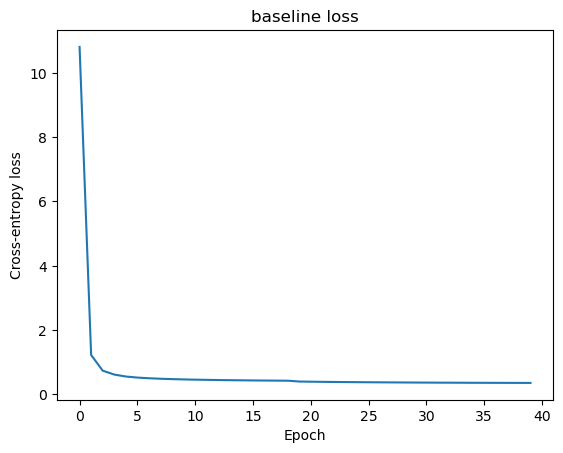

Epochs: 40
Max: 10.806319688697931, epoch: 0
Min: 0.3576966806393737, epoch: 39


In [14]:
loss_list = model_d.get("loss_list")
plt.figure()
plt.title("baseline loss")
plt.ylabel("Cross-entropy loss")
plt.xlabel("Epoch")
plt.plot(loss_list)
plt.show()

print(f"Epochs: {len(loss_list)}")
print(f"Max: {max(loss_list)}, epoch: {np.argmax(loss_list)}")
print(f"Min: {min(loss_list)}, epoch: {np.argmin(loss_list)}")

### Average lengths

In [15]:
tgr_ls = 0
tgr_cs = 0
prd_ls = 0
prd_cs = 0
s = len(model_d.get("source_sentences"))
for tgr, prd in tqdm(zip(model_d.get("source_sentences"), model_d.get("target_sentences"))):
    # tgr = tgr.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    # prd = prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    
    tgr_ls += tgr.count("\n")
    prd_ls += prd.count("\n")
    
    tgr_cs += len(tgr)
    prd_cs += len(prd)
    
print("Average target lines per sample: {:.3f}".format(tgr_ls/s))
print("Average predic lines per sample: {:.3f}".format(prd_ls/s))
print("Average target sample size: {:.3f}".format(tgr_cs/s))
print("Average predic sample size: {:.3f}".format(prd_cs/s))


0it [00:00, ?it/s]

Average target lines per sample: 5.284
Average predic lines per sample: 27.398
Average target sample size: 272.834
Average predic sample size: 970.676


### Examples

In [30]:
# Generate random example from evaluation
samples = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("pred_sentences")))
np.random.shuffle(samples)
for src, tgr, prd in zip(*zip(*samples)):
    
    if (len(tgr) > 100):
        continue
    
    print("SOURCE:")
    print(src)
    print("\nTARGET:")
    print(tgr)
    print("\nPREDICT:")
    # print(prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat"))
    print(prd)
    print("#--------------------------#")
    break

SOURCE:
// value

__global__ void VoteAllKernel2(unsigned int *input, unsigned int *result,
                               int size)<mask>

TARGET:
{
  int tx = threadIdx.x;

  int mask = 0xffffffff;
  result[tx] = __all_sync(mask, input[tx]);
}

PREDICT:
{
  int tid = threadIdx.x + blockDim.x*blockIdxreads();

  if (tid < size) return;

  printf("set World!ree!\n", a,id],�em[tid], tid, tid, stoping_op, stop[t]);
  // stop in sharedizes!\tid] = %0000[id + s, gridDim.  //
   if(tid == 1) {
  ) return;
  }
  else {
}
#--------------------------#


In [52]:
from transformers import pipeline, set_seed
model = model.eval()

while True:
    kernel = list(train_db.aggregate([
        {"$match" : {"metadata.correct_syntax" : True}},
        {"$sample" : {"size": 1}}
    ]))[0]
    
    if len(kernel["body"]) > 200:
        continue

    text_input = "{}{}<mask>".format(kernel["comment"], kernel["header"])

    print("INPUT:")
    print(text_input)

    print("\nTARGET:")
    print(kernel["body"])

    print("\nPREDICT:")
    x = tokenizer(text_input, return_tensors="pt")
    print(tokenizer.batch_decode(model.generate(**x, max_new_tokens=256), skip_special_tokens=True)[0])
    break

    # print(generator(text_input, max_length=256, num_return_sequences=1)[0]["generated_text"])


INPUT:
// Initialize privatized bin counters.  Specialized for privatized shared-memory counters
__device__ __forceinline__ void InitBinCounters()<mask>

TARGET:
{
    if (prefer_smem)
        InitSmemBinCounters();
    else
        InitGmemBinCounters();
}

PREDICT:
{
    if (smem_raking_ptr > linear_tid / blockDim.raizedPLNon_SPNon_2)
  { The smem: % num_full and zero and grid-I >= 0\n", g_PER_TRACKed(0], linear_index, (SPASGetMENT, linear_SPVEC) + (RGB_THREAD)) + local_TYPE) * 0) * num_REERS_VEC_RGB_TYPE> << num_valid_blocks, 0) + src_TYPE_V_dimRow_dim << 3, stream);

   // Copy from the local_share[threadIdx.y + block_rows, 0, input.y;

  }

  int for (int i = 0; col<int i < gridDim.x < 0; i)
}


In [11]:
prompt = """
// Kernel for dividing by two
__device__ float divideByTwo(float v)
""".strip()

target = """
{
    return v / 2;
}
""".strip()

In [12]:
x = tokenizer(prompt, max_length=500, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
x["input_ids"] = x["input_ids"].type(torch.long)
x["attention_mask"] = ~x["attention_mask"].type(torch.bool)
y = tokenizer(target, max_length=500, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
y["input_ids"] = y["input_ids"].type(torch.long)
y["attention_mask"] = ~y["attention_mask"].type(torch.bool)

input_tokens = [token for token in tokenizer.convert_ids_to_tokens(x["input_ids"][0], skip_special_tokens=True)]
target_tokens = [token for token in tokenizer.convert_ids_to_tokens(y["input_ids"][0], skip_special_tokens=True)]

logits, loss = model(x.values(), y.values())
pred = torch.argmax(logits, dim=-1)
pred_tokens = [token for token in tokenizer.convert_ids_to_tokens(pred[0])]
print(f"Loss: {loss:.3f}")
print(tokenizer.batch_decode(pred, skip_special_tokens=True)[0])

Loss: 4.464
//
Two return   two
 two)
__


In [ ]:
from random import shuffle 

searcher = GreedySearch(model, tokenizer, 256)

model = model.train()
losses = []
sample = 1000
l = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences")))
pred_sentences = []
sample_size_loss_list = []
shuffle(l)
for i, (src, tgr) in tqdm(enumerate(l[:sample])):
    x = tokenizer(prompt, max_length=500, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
    x["input_ids"] = x["input_ids"].type(torch.long)
    x["attention_mask"] = ~x["attention_mask"].type(torch.bool)
    y = tokenizer(target, max_length=500, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
    y["input_ids"] = y["input_ids"].type(torch.long)
    y["attention_mask"] = ~y["attention_mask"].type(torch.bool)
    
    
    pred_sentences.append(searcher(*x.values()))
    logits, loss = model(x.values(), y.values())
    pred = torch.max(logits, dim=-1)[1][0]
    
    losses.append(np.random.random()*15)
    pred_sentences.append(tokenizer.decode(pred, skip_special_tokens=True))
    

0it [00:00, ?it/s]

In [20]:
loss_list = losses
input_len_list = []
target_len_list = []

for (src, tgr), prd in zip(l[:sample], pred_sentences):
    input_len_list.append(len(tokenizer.encode(src)))
    target_len_list.append(len(tokenizer.encode(tgr)))
    

/home/samis/miniconda3/envs/diplomka/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


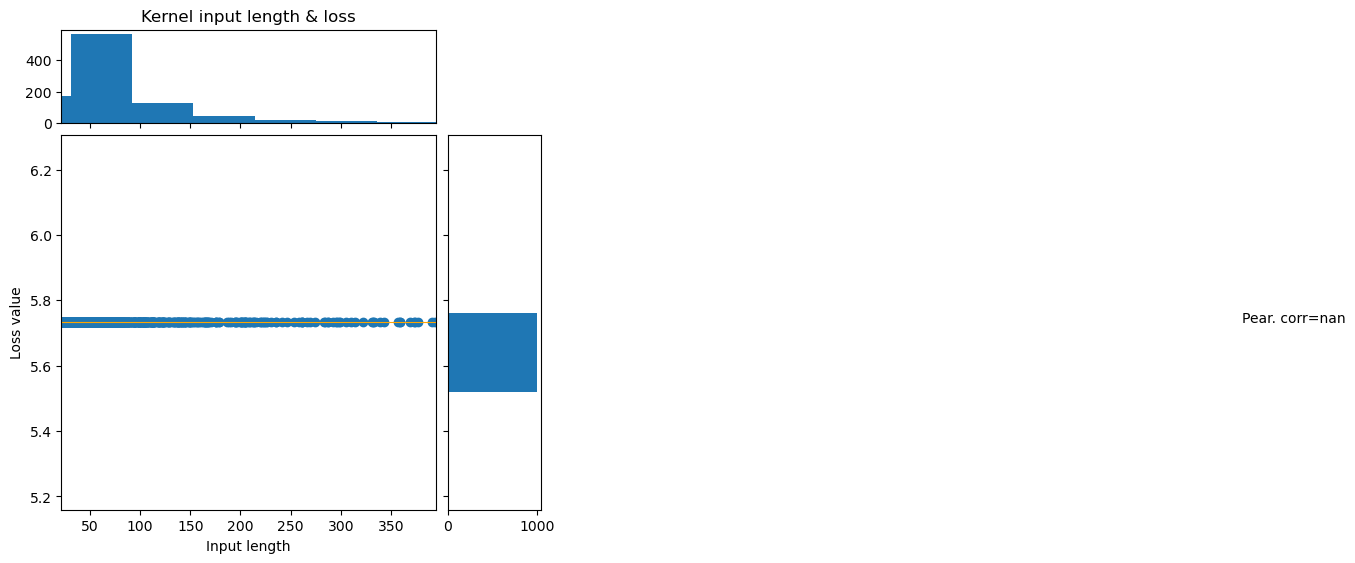

/home/samis/miniconda3/envs/diplomka/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


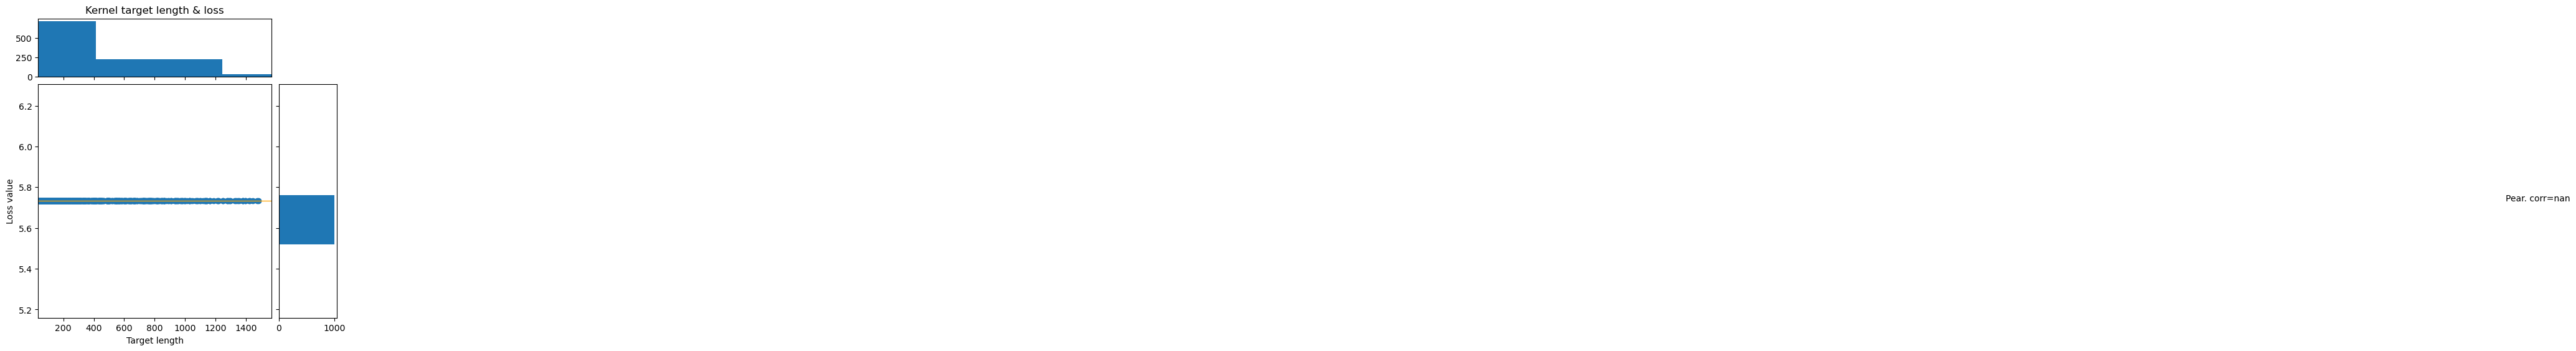

In [23]:
from sklearn.linear_model import LinearRegression 
from scipy.stats import pearsonr

def scatter_hist(x, y, ax, ax_histx, ax_histy, title):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    
    regressor = LinearRegression() 
    regressor.fit(np.array(x).reshape((len(x),1)), y)
    p_y = regressor.predict(np.array(x).reshape((len(x),1)))
    corr, _ = pearsonr(x, y)
    ax.plot(x, p_y, linewidth=0.75, color="orange")
    ax.text(max(x)*0.8, p_y[-1], f"Pear. corr={corr:.2f}")

    # now determine nice limits by hand:
    binwidth = 0.25
    
    xmax = np.max(np.abs(x))
    xlim = (int(xmax/binwidth) + 1) * binwidth
    xbins = np.linspace(-xlim, xlim + binwidth, 50)
    
    ymax = np.max(np.abs(y))
    ylim = (int(ymax/binwidth) + 1) * binwidth
    ybins = np.linspace(-ylim, ylim + binwidth, 50)

    ax_histx.hist(x, bins=xbins)
    ax_histx.set_title(title)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')

def plot_scatter_with_dist(x, y, title, xlabel, ylabel):
    x = np.array(x)
    y = np.array(y)
    
    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    
    min_x = np.quantile(x, 0.05)
    max_x = np.quantile(x, 0.95)
    min_y = np.quantile(y, 0.05)
    max_y = np.quantile(y, 0.95)
    
    # x_mask = ((x > min_x) & (x < max_x))
    # x = x[x_mask]
    # y = y[x_mask]
    # y_mask = ((y > min_y) & (y < max_y))
    # x = x[y_mask]
    # y = y[y_mask]
    
    # Draw the scatter plot and marginals.
    scatter_hist(x, y, ax, ax_histx, ax_histy, title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(min_x*0.9, max_x*1.1)
    ax.set_ylim(min_y*0.9, max_y*1.1)
    plt.show()
    
    
target_len_list = np.array(target_len_list)
input_len_list = np.array(input_len_list)
loss_list = np.array(loss_list)

plot_scatter_with_dist(input_len_list, loss_list, "Kernel input length & loss", "Input length", "Loss value")
plot_scatter_with_dist(target_len_list, loss_list, "Kernel target length & loss", "Target length", "Loss value")


/home/samis/miniconda3/envs/diplomka/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


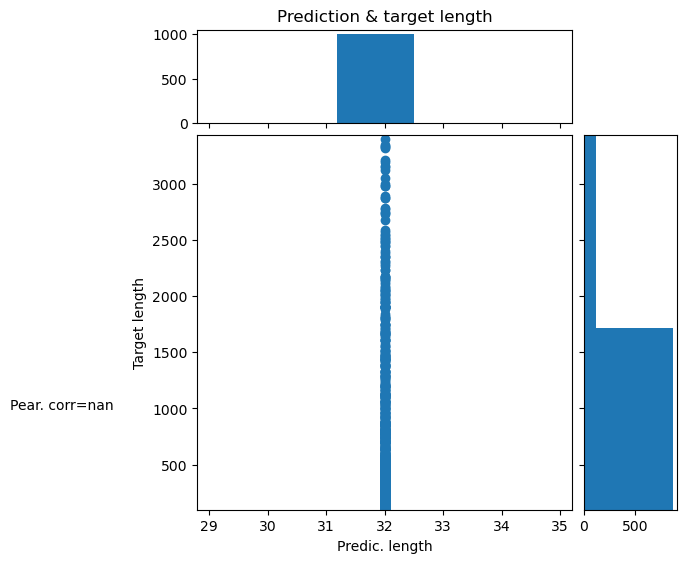

In [25]:
prd_sample_len = []
tgr_sample_len = []

for prd, (_, tgr) in zip(pred_sentences, l[len(pred_sentences):]):
    prd_sample_len.append(len(prd))
    tgr_sample_len.append(len(tgr))

plot_scatter_with_dist(prd_sample_len, tgr_sample_len, "Prediction & target length", "Predic. length", "Target length")
